<a href="https://colab.research.google.com/github/tejasgadgil/RNN-for-KI/blob/main/RNN_for_KI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error
import mplfinance as mpf  # Importing mplfinance for candlestick plotting


In [3]:
# Parameters
stock_symbol = "AAPL"
train_size = 0.8
time_steps = 30

# Fetch stock data
data = yf.download(stock_symbol, start="2015-01-01", end="2024-07-07")
data = data[['Open', 'High', 'Low', 'Close']]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Prepare training and test sets
train_data_len = int(len(scaled_data) * train_size)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len - time_steps:]

In [5]:
# Create datasets with time steps for OHLC prediction
def create_ohlc_dataset(dataset, time_steps):
    x, y = [], []
    for i in range(time_steps, len(dataset)):
        x.append(dataset[i - time_steps:i])
        y.append(dataset[i])  # Predict all four values (OHLC) for the next day
    return np.array(x), np.array(y)


In [6]:
x_train, y_train = create_ohlc_dataset(train_data, time_steps)
x_test, y_test = create_ohlc_dataset(test_data, time_steps)

# Reshape for LSTM (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 4))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 4))

In [7]:
# Build the LSTM model
model = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=4)  # Four outputs for OHLC
])



In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Setup early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',         # or 'val_loss' if you have validation data
    patience=7,             # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restores model to best epoch's weights
)

# Assuming 10% of training data for validation
validation_split = 0.1


# Compile your model (as before)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with validation data and early stopping
model.fit(
    x_train, y_train,
    validation_split=validation_split,
    batch_size=16,
    epochs=20,
    callbacks=[early_stopping]
)

# Predict OHLC prices
predicted_ohlc = model.predict(x_test)
predicted_ohlc = scaler.inverse_transform(predicted_ohlc)  # Undo scaling
y_test_unscaled = scaler.inverse_transform(y_test)  # Undo scaling for actual values

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - loss: 0.0088 - val_loss: 0.0016
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 2.5474e-04 - val_loss: 0.0018
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 2.6098e-04 - val_loss: 0.0012
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 4.0693e-04 - val_loss: 0.0017
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.7950e-04 - val_loss: 0.0013
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.7466e-04 - val_loss: 9.5050e-04
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 1.7373e-04 - val_loss: 0.0016
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.7119e-04 - val_loss: 9.0858e-04
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.4771e-04 - val_loss: 8.1844e-04
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4260e-04 - val_loss: 9.9492e-04
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 1.6485e-04 - v

In [9]:
# Calculate RMSE for each feature (Open, High, Low, Close)
rmse_open = np.sqrt(mean_squared_error(y_test_unscaled[:, 0], predicted_ohlc[:, 0]))
rmse_high = np.sqrt(mean_squared_error(y_test_unscaled[:, 1], predicted_ohlc[:, 1]))
rmse_low = np.sqrt(mean_squared_error(y_test_unscaled[:, 2], predicted_ohlc[:, 2]))
rmse_close = np.sqrt(mean_squared_error(y_test_unscaled[:, 3], predicted_ohlc[:, 3]))
print(f"RMSE - Open: {rmse_open}, High: {rmse_high}, Low: {rmse_low}, Close: {rmse_close}")

RMSE - Open: 3.51240827808543, High: 3.636001471612396, Low: 3.8658353009259883, Close: 4.032111905487127


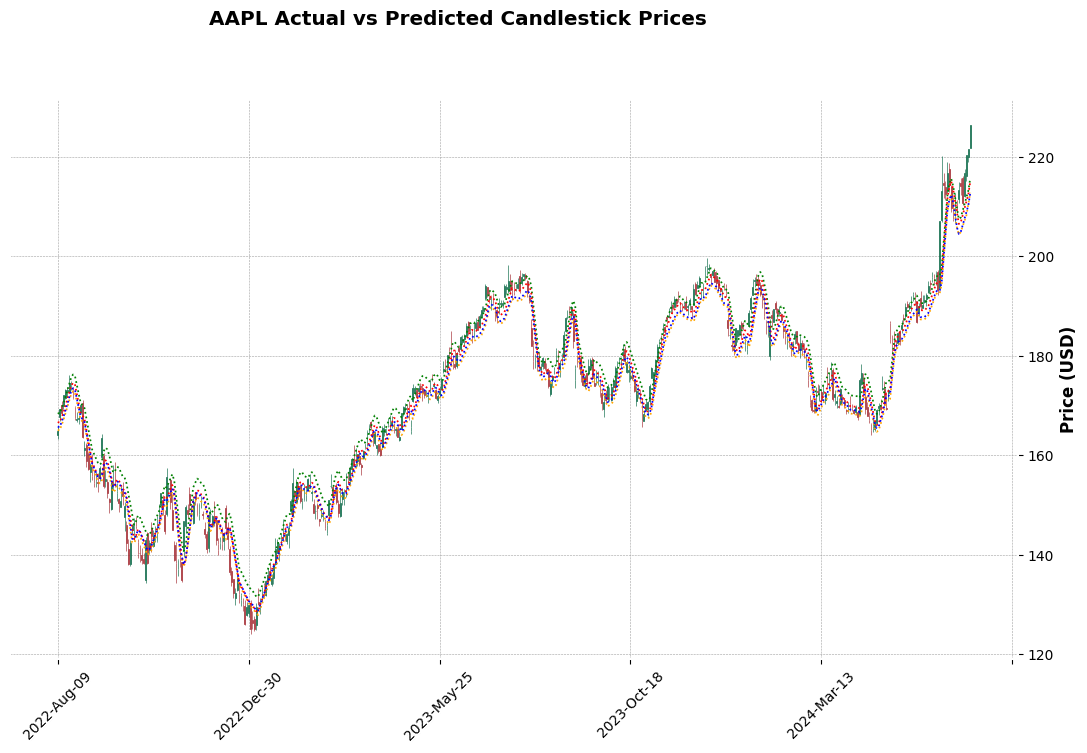

In [10]:
# Prepare DataFrame for plotting
test_dates = data.index[train_data_len:]  # Dates for the test set
actual_candles = pd.DataFrame(y_test_unscaled, columns=['Open', 'High', 'Low', 'Close'], index=test_dates)
predicted_candles = pd.DataFrame(predicted_ohlc, columns=['Open', 'High', 'Low', 'Close'], index=test_dates)

# Plotting with mplfinance
apds = [mpf.make_addplot(predicted_candles['Open'], color='orange', linestyle='dotted', secondary_y=False),
        mpf.make_addplot(predicted_candles['High'], color='green', linestyle='dotted', secondary_y=False),
        mpf.make_addplot(predicted_candles['Low'], color='red', linestyle='dotted', secondary_y=False),
        mpf.make_addplot(predicted_candles['Close'], color='blue', linestyle='dotted', secondary_y=False)]

mpf.plot(actual_candles, type='candle', style='charles', addplot=apds,
         title=f"{stock_symbol} Actual vs Predicted Candlestick Prices",
         ylabel="Price (USD)", figsize=(14, 8))